In [1]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import requests
import os
import numpy as np

import torch
from torchvision import models
from torch.nn import CrossEntropyLoss
from torch.nn.functional import softmax
from torch.optim import Adam,lr_scheduler
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import Dataset

from utils_d import *

device = torch.device("cuda:0")

import sys
sys.path.append(r'D:\codes\python\area51m\pytorch_deeplab_xception')
from pytorch_deeplab_xception.modeling import deeplab

import os
os.environ['TORCH_HOME'] = r'\\DESKTOP-lhj25h0\E\ftp\data\MODELS' 

In [2]:
num_c = 2

dl = deeplab.DeepLab(num_classes=num_c,backbone = 'resnet').to(device)

for name, param in dl.named_parameters():                
    if name.startswith('backbone'):
        param.requires_grad = False

In [3]:
image_size = (250,400)

transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.ColorJitter(brightness = 0.15,
                                                       saturation = 0.1,
                                                       hue = 0.01,
                                                       contrast = 0.15),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [4]:
data = pd.read_csv(r'E:\UCL\Dissertation\label\cropped_lb.csv')

dataset_train = Segdata(transform,image_size,
                        r'cropped_lb.csv',r'E:\UCL\Dissertation\label',['cropped_input','cropped_download'])

dataset_test = Segdata(transform,image_size,
                       r'cropped_lb_test.csv',r'E:\UCL\Dissertation\label',['cropped_input_test','cropped_download_test'])

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=6, 
                                         shuffle=True, num_workers=0,drop_last  = True)

dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=6, num_workers=0,drop_last  = False)

In [5]:
plist = [
         {'params': dl.decoder.parameters(),'lr':1e-2}
         ]

freq = get_frequency(data,image_size,2,r'E:\UCL\Dissertation\label','cropped_download')

criterion = CrossEntropyLoss(weight=1/freq)

optimizer = Adam(params=plist)

scheduler = lr_scheduler.StepLR(optimizer, step_size=33,gamma=0.1)

loss_list = []

best_val_loss = float('inf')

n_epoch = 1

In [6]:
for epoch in range(n_epoch):
    training_loss,training_iou = train(dl,dataloader_train,optimizer,criterion,loss_list,num_c)
    val_loss,val_iou = evaluate(dl,dataloader_test,criterion,num_c)
    scheduler.step()
    print('finished {0}th training'.format(epoch+1))
    print('training loss: {0}, training iou: {1}'.format(training_loss.item(),training_iou))
    print('validation loss: {0}, validation iou: {1}'.format(val_loss.item(),val_iou))
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(dl.state_dict(), r'E:\UCL\Dissertation\label\model_deeplabv3+resnet.pt')

finished 1th training
training loss: 0.6063100880589979, training iou: 0.40848583319292103
validation loss: 0.5739181280136109, validation iou: 0.4300800965743753


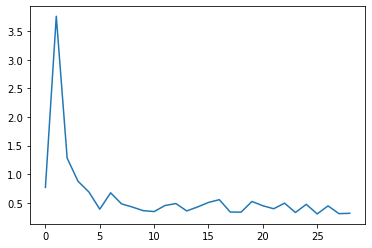

In [7]:
plt.plot(loss_list)